In [1]:
import os
os.listdir('/kaggle/input')

['car-damage-detection']

In [2]:
BASE_DIR = "/kaggle/input/car-damage-detection/data1a"

In [3]:
print("Folders inside BASE_DIR:", os.listdir(BASE_DIR))
print("Training folders:", os.listdir(os.path.join(BASE_DIR, "training")))
print("Validation folders:", os.listdir(os.path.join(BASE_DIR, "validation")))

Folders inside BASE_DIR: ['validation', 'training']
Training folders: ['00-damage', '01-whole']
Validation folders: ['00-damage', '01-whole']


In [4]:
import tensorflow as tf
print(tf.__version__)


2025-12-21 15:50:45.835925: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766332246.011331      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766332246.056293      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766332246.419467      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766332246.419507      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766332246.419511      55 computation_placer.cc:177] computation placer alr

2.19.0


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [6]:
# --- Define Dataset Paths and Categories ---
TRAIN_DIR = os.path.join(BASE_DIR, "training")
VAL_DIR   = os.path.join(BASE_DIR, "validation")

CATEGORIES = ["00-damage", "01-whole"]

print("Training path:", TRAIN_DIR)
print("Validation path:", VAL_DIR)

Training path: /kaggle/input/car-damage-detection/data1a/training
Validation path: /kaggle/input/car-damage-detection/data1a/validation


In [7]:
# --- Load and Preprocess Images ---

print("[INFO] Loading and preprocessing images...")

data = []
labels = []

for folder in ["training", "validation"]:
    for category in CATEGORIES:
        folder_path = os.path.join(BASE_DIR, folder, category)
        print(f"Processing {folder}/{category}...")

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            try:
                # Load image and resize to 224x224
                image = load_img(img_path, target_size=(224, 224))
                image = img_to_array(image)
                image = preprocess_input(image)   # Normalize to [-1,1] for MobileNetV2

                data.append(image)
                labels.append(category)
            except Exception as e:
                print(f"[Warning] Skipped {img_path}: {e}")

print(f"[INFO] Total images loaded: {len(data)}")

[INFO] Loading and preprocessing images...
Processing training/00-damage...
Processing training/01-whole...
Processing validation/00-damage...
Processing validation/01-whole...
[INFO] Total images loaded: 2300


In [8]:
# --- Encode Labels (with one-hot encoding) ---

lb = LabelBinarizer()
labels_encoded = lb.fit_transform(labels)
print("Classes:", lb.classes_)
print("Sample encoded label (before one-hot):", labels_encoded[0])

# Convert to one-hot vectors
labels_encoded = to_categorical(labels_encoded)
print("Sample encoded label (after one-hot):", labels_encoded[0])

Classes: ['00-damage' '01-whole']
Sample encoded label (before one-hot): [0]
Sample encoded label (after one-hot): [1. 0.]


In [9]:
# --- Convert Lists to NumPy Arrays ---

data = np.array(data, dtype="float32")
labels = np.array(labels_encoded)

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (2300, 224, 224, 3)
Labels shape: (2300, 2)


In [10]:
# --- Split Into Train/ Validation /Test Sets ---

trainX, tempX, trainY, tempY = train_test_split(data, labels, test_size=0.30, stratify=labels,
                                                random_state=42)

valX, testX, valY, testY = train_test_split(tempX, tempY,test_size=0.50, stratify=tempY,
                                            random_state=42)

print("Train:", trainX.shape, trainY.shape)
print("Validation:", valX.shape, valY.shape)
print("Test:", testX.shape, testY.shape)

Train: (1610, 224, 224, 3) (1610, 2)
Validation: (345, 224, 224, 3) (345, 2)
Test: (345, 224, 224, 3) (345, 2)


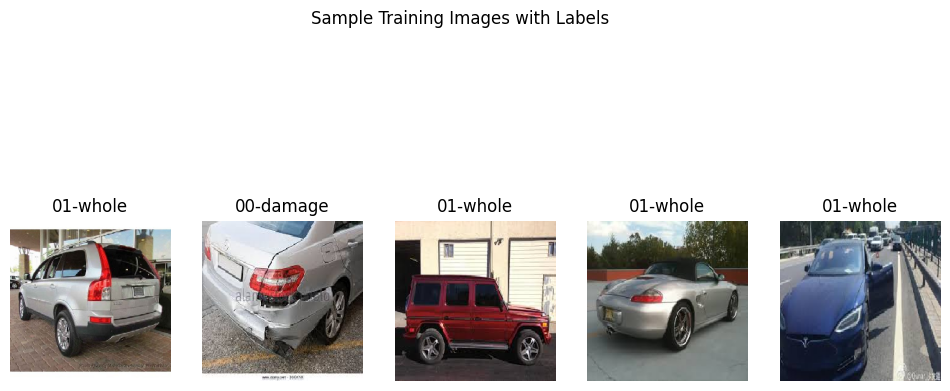

In [11]:
# --- Visualize a Few Random Sample Images ---

indices = random.sample(range(len(trainX)), 5)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(1, 5, i + 1)
    img = (trainX[idx] + 1) / 2.0           # Convert back to [0,1] for display
    label_idx = np.argmax(trainY[idx])       # Decode one-hot to class index
    label_name = lb.classes_[label_idx]      # Convert index → class label
    plt.imshow(img)
    plt.title(label_name)
    plt.axis("off")

plt.suptitle("Sample Training Images with Labels")
plt.show()

In [12]:
# --- Save Preprocessed Data to Reuse Later ---

np.save("trainX.npy", trainX)
np.save("trainY.npy", trainY)

np.save("valX.npy", valX)
np.save("valY.npy", valY)

np.save("testX.npy", testX)
np.save("testY.npy", testY)

print("[INFO] All preprocessed data (train / val / test) saved successfully!")


[INFO] All preprocessed data (train / val / test) saved successfully!


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import math
import seaborn as sns

print("[INFO] Libraries loaded successfully.")

[INFO] Libraries loaded successfully.


In [14]:
LOAD_DIR = "/kaggle/working/"

trainX = np.load(f"{LOAD_DIR}/trainX.npy")
trainY = np.load(f"{LOAD_DIR}/trainY.npy")
valX  = np.load(f"{LOAD_DIR}/valX.npy")
valY  = np.load(f"{LOAD_DIR}/valY.npy")

print("trainX:", trainX.shape)
print("trainY:", trainY.shape)
print("valX :", testX.shape)
print("valY :", testY.shape)

trainX: (1610, 224, 224, 3)
trainY: (1610, 2)
valX : (345, 224, 224, 3)
valY : (345, 2)


In [15]:
print(valX[0])

[[[-0.3333333  -0.2862745  -0.8666667 ]
  [-0.06666666  0.01176476 -0.46666664]
  [-0.24705881 -0.15294117 -0.5137255 ]
  ...
  [ 1.          1.          1.        ]
  [ 1.          1.          1.        ]
  [ 1.          1.          1.        ]]

 [[-0.36470586 -0.36470586 -0.77254903]
  [-0.29411763 -0.23921567 -0.58431375]
  [-0.27843136 -0.19999999 -0.46666664]
  ...
  [ 1.          1.          1.        ]
  [ 1.          1.          1.        ]
  [ 1.          1.          1.        ]]

 [[-0.35686272 -0.35686272 -0.7490196 ]
  [-0.4352941  -0.38823527 -0.7490196 ]
  [ 0.13725495  0.22352946 -0.09019607]
  ...
  [ 0.99215686  0.99215686  0.99215686]
  [ 0.99215686  0.99215686  0.99215686]
  [ 1.          1.          1.        ]]

 ...

 [[-0.2862745  -0.25490195 -0.1607843 ]
  [-0.45098037 -0.4352941  -0.3333333 ]
  [-0.5372549  -0.52156866 -0.41960782]
  ...
  [-0.3098039  -0.26274508 -0.16862744]
  [-0.26274508 -0.21568626 -0.12156862]
  [-0.3960784  -0.3490196  -0.25490195]]

 [

In [16]:
# --- Load base MobileNetV2 model ---
baseModel = MobileNetV2(weights="imagenet",
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

# --- Add custom classification head ---
headModel = baseModel.output
headModel = MaxPooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# --- Combine base & head ---
model = Model(inputs=baseModel.input, outputs=headModel)

# --- Freeze base layers (train only top) ---
for layer in baseModel.layers:
    layer.trainable = False

print("[INFO] Model created successfully.")
model.summary()

/tmp/ipykernel_55/806057595.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet",
I0000 00:00:1766332344.113393      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
[INFO] Model created successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
INIT_LR = 1e-5     # learning rate
EPOCHS = 100
# --- Compile model ---
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print("[INFO] Model compiled.")

[INFO] Model compiled.


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [18]:
import math

BS = 32            # batch size
factor = 8

# --- Data Augmentation ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),      # ~ rotation_range=20deg
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.2, 0.2),
], name="data_augmentation")

def augment(x, y):
    x = data_augmentation(x, training=True)  # random each batch
    return x, y

def identity(x, y):
    return x, y

print("[INFO] Data augmentation ready.")

[INFO] Data augmentation ready.


In [19]:
# --- Callbacks ---
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_mobilenetv2.keras", monitor="val_accuracy", save_best_only=True)
reduce_lr  = ReduceLROnPlateau(monitor="val_accuracy", mode="max", factor=0.5, patience=3, min_lr=1e-6)

# --- Build tf.data pipelines ---

# base dataset (infinite)
base_ds = tf.data.Dataset.from_tensor_slices((trainX, trainY)).shuffle(len(trainX)).repeat()

orig_dataset = base_ds.batch(BS).map(identity, num_parallel_calls=tf.data.AUTOTUNE)
aug_dataset  = base_ds.batch(BS).map(augment,  num_parallel_calls=tf.data.AUTOTUNE)

# 3) mix them 50/50
mixed_dataset = tf.data.Dataset.sample_from_datasets(
    [orig_dataset, aug_dataset], weights=[0.5, 0.5]
).prefetch(tf.data.AUTOTUNE)

steps_per_epoch = factor * math.ceil(len(trainX) / BS)

# --- Train ---
print("[INFO] Training started...")
H = model.fit(
    mixed_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=(valX, valY),
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose = 1
)
print("[INFO] Training completed.")

[INFO] Training started...
Epoch 1/100


I0000 00:00:1766332382.659483     126 service.cc:152] XLA service 0x7a6948113bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766332382.659528     126 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766332383.653698     126 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1766332389.381886     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 109ms/step - accuracy: 0.5624 - loss: 2.4360 - val_accuracy: 0.8435 - val_loss: 0.4142 - learning_rate: 1.0000e-05
Epoch 2/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - accuracy: 0.6986 - loss: 1.0065 - val_accuracy: 0.8696 - val_loss: 0.2932 - learning_rate: 1.0000e-05
Epoch 3/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - accuracy: 0.7468 - loss: 0.6430 - val_accuracy: 0.8841 - val_loss: 0.2731 - learning_rate: 1.0000e-05
Epoch 4/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.7741 - loss: 0.5261 - val_accuracy: 0.8754 - val_loss: 0.2681 - learning_rate: 1.0000e-05
Epoch 5/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 36s 89ms/step - accuracy: 0.7916 - loss: 0.4692 - val_accuracy: 0.8928 - val_loss: 0.2587 - learning_rate: 1.0000e-05
Epoch 6/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.8114 - loss: 0.4171 - val_accuracy: 0.8986 - val_loss: 0.2515 - learning_rate: 1.0000e-05
Epoch 7/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 33s 80ms/step - 

In [24]:
model.save("/kaggle/working/MobileNet_Car_detection_Final.h5")

[INFO] Evaluating model...
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 405ms/step
              precision    recall  f1-score   support

   00-damage       0.96      0.93      0.94       173
    01-whole       0.93      0.96      0.95       172

    accuracy                           0.94       345
   macro avg       0.95      0.94      0.94       345
weighted avg       0.95      0.94      0.94       345



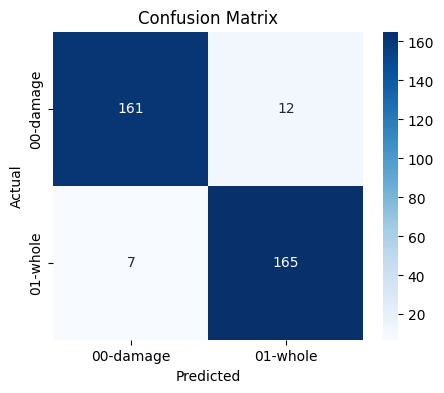

In [25]:
# --- Evaluate model on validation ---
print("[INFO] Evaluating model...")
predIdxs = model.predict(valX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
trueIdxs = np.argmax(valY, axis=1)

# --- Classification report ---
print(classification_report(trueIdxs, predIdxs, target_names=["00-damage", "01-whole"]))

# --- Confusion matrix ---
cm = confusion_matrix(trueIdxs, predIdxs)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["00-damage","01-whole"],
            yticklabels=["00-damage","01-whole"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

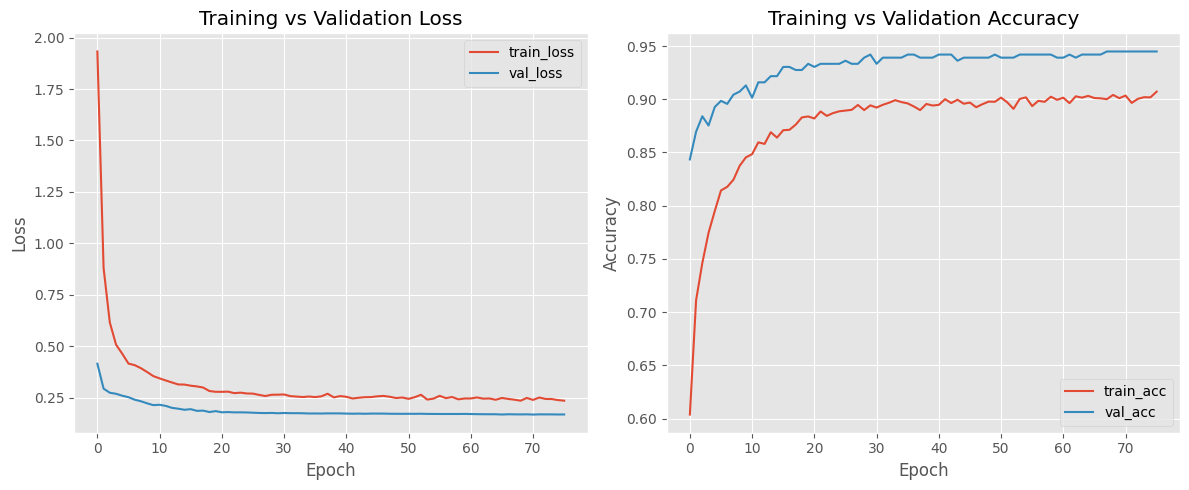

In [26]:
# --- Plot accuracy/loss curves ---
N = len(H.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
from tensorflow.keras.optimizers import Adam

print("[INFO] Unfreezing last 20 layers of MobileNetV2 for fine‑tuning...")

#--- Unfreeze some layers in the base model ---
for layer in baseModel.layers[-20:]:
    layer.trainable = True

#--- Re‑compile with smaller learning rate ---
opt_finetune = Adam(learning_rate=1e-6)
model.compile(loss="categorical_crossentropy", optimizer=opt_finetune, metrics=["accuracy"])

print("[INFO] Model recompiled for fine‑tuning with lower LR and last 20 layers trainable.")

#--- Optional class weighting if you care more about "damage" detection ---
class_weight = {0: 1.0, 1: 1.0}  # keep if you want higher recall for "damage"

#--- Define new training parameters ---
EPOCHS_FINETUNE = 10
BS = 32
steps_per_epoch = factor * math.ceil(len(trainX) / BS)  # reuse your augmentation factor

print("[INFO] Starting fine‑tuning phase...")

#--- Fine‑tune using your existing tf.data *mixed_dataset* ---
H_finetune = model.fit(
    mixed_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=(testX, testY),
    epochs=EPOCHS_FINETUNE,
    class_weight=class_weight,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

print("[INFO] Fine‑tuning completed!")

[INFO] Unfreezing last 20 layers of MobileNetV2 for fine‑tuning...
[INFO] Model recompiled for fine‑tuning with lower LR and last 20 layers trainable.
[INFO] Starting fine‑tuning phase...
Epoch 1/10


2025-12-21 16:47:34.021602: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 16:47:34.218311: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 101ms/step - accuracy: 0.8393 - loss: 0.3804 - val_accuracy: 0.9304 - val_loss: 0.1791 - learning_rate: 1.0000e-06
Epoch 2/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 30s 75ms/step - accuracy: 0.8547 - loss: 0.3535 - val_accuracy: 0.9275 - val_loss: 0.1779 - learning_rate: 1.0000e-06
Epoch 3/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.8636 - loss: 0.3367 - val_accuracy: 0.9188 - val_loss: 0.1875 - learning_rate: 1.0000e-06
Epoch 4/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 35s 87ms/step - accuracy: 0.8665 - loss: 0.3219 - val_accuracy: 0.9188 - val_loss: 0.1955 - learning_rate: 1.0000e-06
Epoch 5/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 36s 87ms/step - accuracy: 0.8775 - loss: 0.2949 - val_accuracy: 0.9217 - val_loss: 0.1988 - learning_rate: 1.0000e-06
Epoch 6/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - accuracy: 0.8737 - loss: 0.2968 - val_accuracy: 0.9246 - val_loss: 0.1996 - learning_rate: 1.0000e-06
Epoch 7/10
408/408 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - accura

[INFO] Evaluating model...
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 412ms/step
              precision    recall  f1-score   support

   00-damage       0.97      0.91      0.94       173
    01-whole       0.92      0.97      0.94       172

    accuracy                           0.94       345
   macro avg       0.94      0.94      0.94       345
weighted avg       0.94      0.94      0.94       345



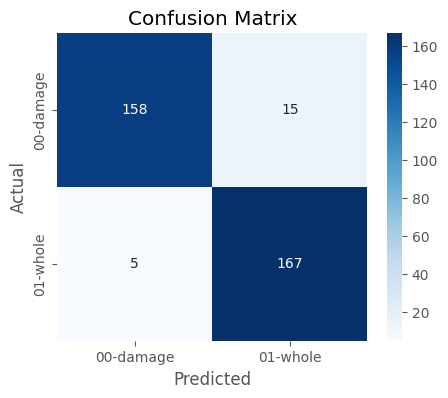

In [28]:
# --- Evaluate model on validation ---
print("[INFO] Evaluating model...")
predIdxs = model.predict(valX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
trueIdxs = np.argmax(valY, axis=1)

# --- Classification report ---
print(classification_report(trueIdxs, predIdxs, target_names=["00-damage", "01-whole"]))

# --- Confusion matrix ---
cm = confusion_matrix(trueIdxs, predIdxs)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["00-damage","01-whole"],
            yticklabels=["00-damage","01-whole"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [30]:
model.save("/kaggle/working/MobileNet_Car_detection_Final_fineTuning.keras")

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow import keras

# Load your trained model
MODEL_PATH = "/kaggle/working/MobileNet_Car_detection_Final_fineTuning.keras"
model = keras.models.load_model(MODEL_PATH)
print("[INFO] Model loaded successfully!")

[INFO] Model loaded successfully!


In [32]:
# Define Class Names
CATEGORIES = ["00-damage", "01-whole"]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


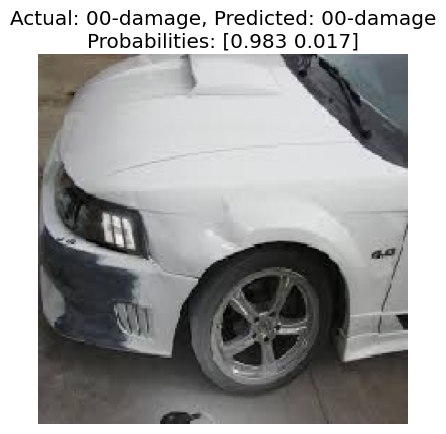

In [36]:
import numpy as np

DATA_PATH = "/kaggle/working"  # Or your dataset path if using Kaggle input
trainX = np.load(f"{DATA_PATH}/trainX.npy")
trainY = np.load(f"{DATA_PATH}/trainY.npy")

# Optional: load categories (assuming you saved them manually)
categories = ["00-damage", "01-whole"]

import random
import matplotlib.pyplot as plt
import numpy as np

# Random index
idx = random.randint(0, len(trainX)-1)

# Get image and label
img_array = trainX[idx]
true_label_idx = np.argmax(trainY[idx])
true_label = categories[true_label_idx]

# Add batch dimension
img_input = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_input)[0]

# Thresholding (for binary classification)
threshold = 0.4
pred_label = categories[0] if pred[0] > threshold else categories[1]


# Convert image back to [0,1] for plotting
plt.imshow((img_array + 1) / 2.0)
plt.axis("off")
plt.title(f"Actual: {true_label}, Predicted: {pred_label}\nProbabilities: {np.round(pred, 3)}")
plt.show()


In [37]:
import tensorflow as tf
from tensorflow import keras

tta_augment = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomTranslation(0.05, 0.05)
])

In [38]:
def tta_predict(model, image, n=8, threshold=0.5):
    preds = []

    # expand dims once (image already normalized)
    img = tf.expand_dims(image, axis=0)

    for _ in range(n):
        aug_img = tta_augment(img, training=True)
        pred = model.predict(aug_img, verbose=0)[0]
        preds.append(pred)

    # average predictions
    mean_pred = np.mean(preds, axis=0)

    # apply your custom threshold to class 0 (damage)
    label = "00-damage" if mean_pred[0] > threshold else "01-whole"

    return mean_pred, label

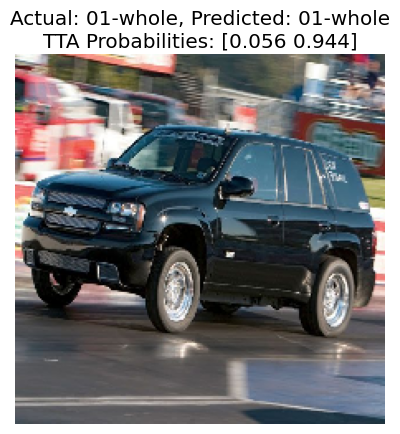

In [39]:
valX = np.load(f"{DATA_PATH}/valX.npy")
valY = np.load(f"{DATA_PATH}/valY.npy")

# Pick a random validation sample
idx = random.randint(0, len(valX)-1)
img_array = valX[idx]
true_label_idx = np.argmax(valY[idx])
true_label = categories[true_label_idx]

# TTA prediction (8 augmentations)
mean_pred, label = tta_predict(model, img_array, n=8, threshold=threshold)

# Display
plt.imshow((img_array + 1) / 2.0)  # convert back to [0,1] for plotting
plt.axis("off")
plt.title(f"Actual: {true_label}, Predicted: {label}\nTTA Probabilities: {np.round(mean_pred, 3)}")
plt.show()


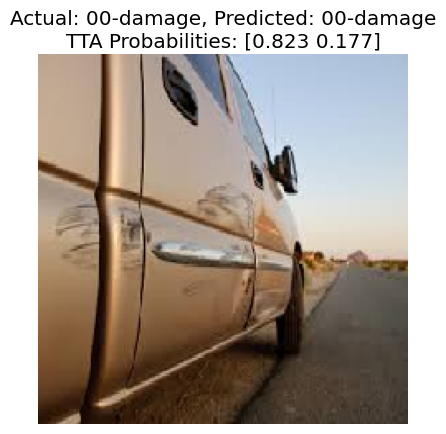

In [41]:
trainX = np.load(f"{DATA_PATH}/trainX.npy")
trainY = np.load(f"{DATA_PATH}/trainY.npy")

# Pick a random test sample
idx = random.randint(0, len(testX)-1)
img_array = testX[idx]
true_label_idx = np.argmax(testY[idx])
true_label = categories[true_label_idx]

# TTA prediction (8 augmentations)
mean_pred, label = tta_predict(model, img_array, n=8, threshold=threshold)

# Display
plt.imshow((img_array + 1) / 2.0)  # convert back to [0,1] for plotting
plt.axis("off")
plt.title(f"Actual: {true_label}, Predicted: {label}\nTTA Probabilities: {np.round(mean_pred, 3)}")
plt.show()

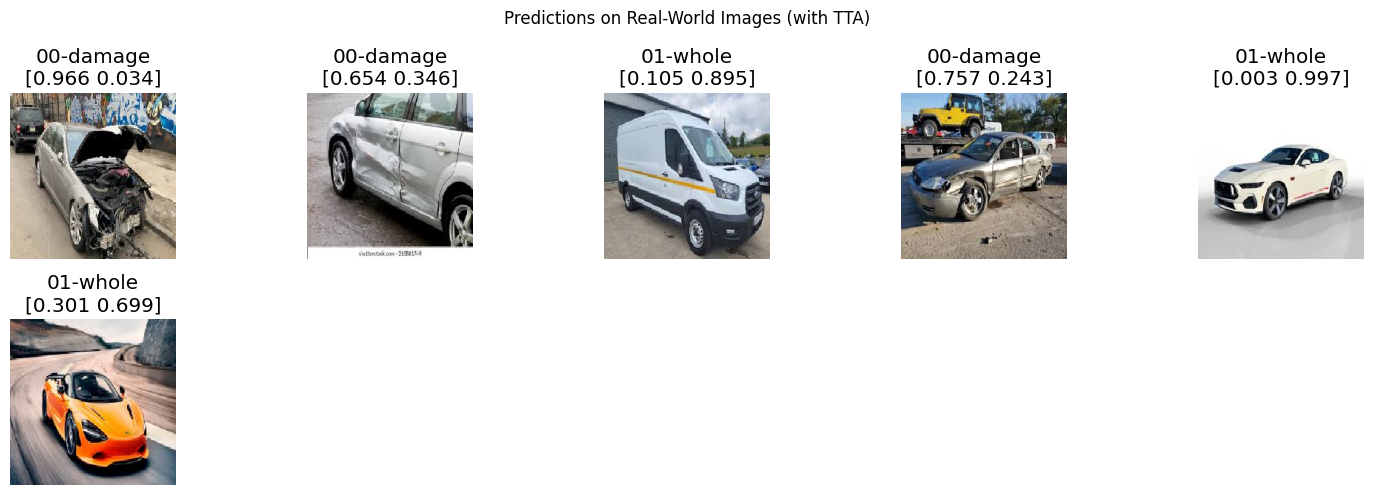

In [51]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Directory with real-world images
IMG_DIR = "/kaggle/input/real-world-test-0"

# List all images
img_files = [f for f in os.listdir(IMG_DIR) if f.lower().endswith((".jpg"))]

# Prepare figure
plt.figure(figsize=(15, 5))

for i, img_name in enumerate(img_files):
    img_path = os.path.join(IMG_DIR, img_name)
    
    # Load + preprocess
    image = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(image)
    img_array = (img_array / 127.5) - 1.0  # MobileNetV2 preprocessing
    
    # TTA prediction (same logic as before)
    mean_pred, pred_label = tta_predict(model, img_array, n=8, threshold=threshold)
    
    # Plot
    plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
    plt.imshow((img_array + 1)/2.0)  # back to [0,1] for plotting
    plt.axis("off")
    plt.title(f"{pred_label}\n{np.round(mean_pred, 3)}")

plt.suptitle("Predictions on Real-World Images (with TTA)")
plt.tight_layout()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Test Accuracy: 92.75%
Classification Report:
               precision    recall  f1-score   support

   00-damage       0.92      0.94      0.93       172
    01-whole       0.94      0.92      0.93       173

    accuracy                           0.93       345
   macro avg       0.93      0.93      0.93       345
weighted avg       0.93      0.93      0.93       345



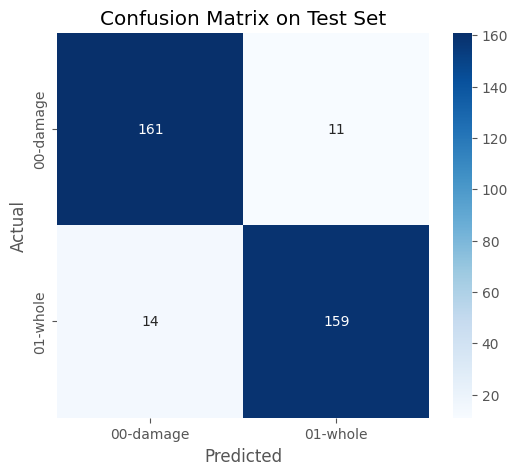

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

testX = np.load(f"{DATA_PATH}/testX.npy")
testY = np.load(f"{DATA_PATH}/testY.npy")

pred_probs = model.predict(testX)  # shape: (num_samples, 2)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(testY, axis=1)

# --- Accuracy ---
acc = accuracy_score(true_labels, pred_labels)
print(f"Test Accuracy: {acc*100:.2f}%")

# --- Classification Report ---
report = classification_report(true_labels, pred_labels, target_names=categories)
print("Classification Report:\n", report)

# --- Confusion Matrix ---
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()